**Bibliteca de Videojuegos**

Esta biblioteca es un programa personal que permite almacenar y gestionar tus videojuegos físicos y digitales. Ofrece la posibilidad de editar la información existente, agregar nuevos datos y realizar un análisis de la colección.

Para el correcto funcionamiento del código, es necesario contar con el archivo vgsales.csv. Este archivo puede ser reemplazado por otro archivo .csv, preferiblemente uno que contenga datos actualizados hasta el año 2025 e incluya una columna de precio. Esto permitirá, en futuras versiones del programa, implementar una función de predicción de compras basada en dicha información. También existe la posibilidad de utilizar un archivo CSV proveniente de la tienda Steam, el cual podría integrarse fácilmente al sistema.

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo vgsales.csv en Colab
vgsales_drive_path = "/content/drive/MyDrive/vgsales.csv"

# Verificar si vgsales.csv existe en el entorno de Colab
if os.path.exists(vgsales_drive_path):
    print(f"✅ Archivo '{vgsales_drive_path}' encontrado.")
else:
    print(f"⚠️ No se encontró el archivo '{vgsales_drive_path}' en el entorno de Colab.")

Mounted at /content/drive
✅ Archivo '/content/drive/MyDrive/vgsales.csv' encontrado.


In [ ]:
import pandas as pd
import os

class BibliotecaVideojuegos:
    def __init__(self):
        self.df = pd.DataFrame(columns=["nombre", "genero", "tiempo_estimado", "desarrollador", "anio", "costo"])
        self.vgsales = self.cargar_csv_vgsales()

    def cargar_csv_vgsales(self, path="/content/drive/MyDrive/vgsales.csv"):
        if os.path.exists(path):
            df_csv = pd.read_csv(path)
            # Renombrar 'Nombre' (con N mayúscula) a 'nombre' para consistencia
            if 'Nombre' in df_csv.columns:
                df_csv.rename(columns={'Nombre': 'nombre'}, inplace=True)

            if "Genre" in df_csv.columns:
                df_csv["Genre"] = df_csv["Genre"].replace({
                    "Action": "Acción",
                    "Adventure": "Aventura",
                    "Fighting": "Lucha",
                    "Misc": "Música",
                    "Platform": "Plataformas",
                    "Puzzle": "Puzzle",
                    "Racing": "Carreras",
                    "Role-Playing": "Rol",
                    "Shooter": "Disparos",
                    "Simulation": "Simulación",
                    "Sports": "Deportes",
                    "Strategy": "Estrategia"
                })
            return df_csv
        return None

    def agregar_juego(self, nombre, genero, tiempo_estimado, desarrollador, anio, costo="0"):
        info = self.autocompletar_info(nombre)
        nombre = nombre or info.get("nombre", "")
        genero = genero or info.get("genero", "")
        tiempo_estimado = tiempo_estimado or info.get("tiempo_estimado", "")
        desarrollador = desarrollador or info.get("desarrollador", "")
        anio = anio or info.get("anio", "")
        costo = costo if costo else "0"

        nuevo = pd.DataFrame([{
            "nombre": nombre,
            "genero": genero,
            "tiempo_estimado": tiempo_estimado,
            "desarrollador": desarrollador,
            "anio": anio,
            "costo": costo
        }])
        self.df = pd.concat([self.df, nuevo], ignore_index=True)
        print("✅ Juego agregado correctamente.")

    def listar_juegos(self):
        if self.df.empty:
            print("📭 No hay juegos en la biblioteca.")
        else:
            print("\n🎮 Lista de Videojuegos:")
            print(self.df.to_string(index=True))

    def buscar_por_nombre(self, nombre):
        resultado = self.df[self.df["nombre"].str.contains(nombre, case=False, na=False)]
        print(resultado if not resultado.empty else "🔍 No se encontraron coincidencias.")

    def filtrar_por_genero(self, genero):
        resultado = self.df[self.df["genero"].str.lower() == genero.lower()]
        print(resultado if not resultado.empty else "🔍 No hay juegos con ese género.")

    def editar_juego(self, identificador):
        try:
            if identificador.isdigit():
                indice = int(identificador)
                if indice < 0 or indice >= len(self.df):
                    print("❌ Índice fuera de rango.")
                    return
            else:
                indice = self.df.index[self.df["nombre"].str.lower() == identificador.lower()].tolist()[0]
        except:
            print("❌ No se encontró el juego.")
            return

        print("🔧 Deja en blanco para mantener el valor actual.")
        nombre = input(f"Nuevo nombre [{self.df.at[indice, 'nombre']}]: ") or self.df.at[indice, "nombre"]
        genero = input(f"Nuevo género [{self.df.at[indice, 'genero']}]: ") or self.df.at[indice, "genero"]
        tiempo = input(f"Nuevo tiempo estimado [{self.df.at[indice, 'tiempo_estimado']}]: ") or self.df.at[indice, "tiempo_estimado"]
        desarrollador = input(f"Nuevo desarrollador [{self.df.at[indice, 'desarrollador']}]: ") or self.df.at[indice, "desarrollador"]
        anio = input(f"Nuevo año [{self.df.at[indice, 'anio']}]: ") or self.df.at[indice, "anio"]
        costo_actual = self.df.at[indice, 'costo'] if self.df.at[indice, 'costo'] else 0
        costo = input(f"Nuevo costo (USD) [{costo_actual}]: ") or self.df.at[indice, "costo"]

        self.df.loc[indice] = [nombre, genero, tiempo, desarrollador, anio, costo]
        print("✅ Juego actualizado.")

    def eliminar_juego(self, indice):
        try:
            self.df = self.df.drop(index=indice).reset_index(drop=True)
            print("🗑️ Juego eliminado.")
        except:
            print("❌ No se pudo eliminar el juego.")

    def guardar_en_archivo(self, archivo="biblioteca.json"):
        self.df.to_json(archivo, orient="records", indent=4)
        print(f"💾 Biblioteca guardada en {archivo}")

    def cargar_desde_archivo(self, archivo="biblioteca.json"):
        if os.path.exists(archivo):
            try:
                self.df = pd.read_json(archivo)
                if 'costo' not in self.df.columns:
                    self.df['costo'] = 0
                print(f"📥 Biblioteca cargada desde {archivo}")
            except:
                print("⚠️ Error al cargar el archivo.")

    def autocompletar_info(self, nombre):
        if self.vgsales is not None:
            # Usar 'nombre' en lugar de 'Name'
            resultado = self.vgsales[self.vgsales["nombre"].str.contains(nombre, case=False, na=False)]
            if not resultado.empty:
                fila = resultado.iloc[0]
                return {
                    "nombre": fila["nombre"],
                    "genero": fila["Genero"],
                    "desarrollador": fila.get("Publisher", ""),
                    "anio": fila.get("Year", "")
                }
        return {}

    def filtrar_por_genero_y_tiempo(self, genero, tiempo_max):
        try:
            tiempo_max = float(tiempo_max)
            resultado = self.df[
                (self.df["genero"].str.lower() == genero.lower()) &
                (pd.to_numeric(self.df["tiempo_estimado"], errors="coerce") <= tiempo_max)
            ]
            print(resultado if not resultado.empty else "🔍 No hay coincidencias.")
        except ValueError:
            print("❌ El tiempo debe ser un número válido.")

    def filtrar_por_precio(self, precio_min, precio_max):
        try:
            precio_min = float(precio_min)
            precio_max = float(precio_max)
            resultado = self.df[
                (pd.to_numeric(self.df["costo"], errors="coerce") >= precio_min) &
                (pd.to_numeric(self.df["costo"], errors="coerce") <= precio_max)
            ]
            print(resultado if not resultado.empty else "🔍 No hay juegos en ese rango de precio.")
        except ValueError:
            print("❌ Los valores deben ser números válidos.")

    def descargar_en_json(self, archivo="biblioteca.json"):
        self.df.to_json(archivo, orient="records", indent=4)
        print(f"⬇️ Biblioteca descargada en {archivo}")


def menu():
    biblioteca = BibliotecaVideojuegos()
    archivo = "biblioteca.json"
    biblioteca.cargar_desde_archivo(archivo)

    while True:
        print("\n📚 MENÚ BIBLIOTECA DE VIDEOJUEGOS")
        print("1. Agregar videojuego")
        print("2. Listar todos los juegos")
        print("3. Filtrar por género")
        print("4. Buscar por nombre")
        print("5. Editar un juego")
        print("6. Eliminar un juego")
        print("7. Guardar biblioteca")
        print("8. Filtrar por género y tiempo estimado (en horas)")
        print("9. Filtrar por precio en dólares")
        print("10. Descargar biblioteca en JSON")
        print("11. Salir")

        opcion = input("Elige una opción: ").strip()

        if opcion == "1":
            nombre = input("Nombre del videojuego: ")
            info = biblioteca.autocompletar_info(nombre) if biblioteca.vgsales is not None else {}
            genero = input(f"Género [{info.get('genero','')}] : ") or info.get("genero", "")
            tiempo = input("Tiempo estimado de juego (en horas): ")
            desarrollador = input(f"Desarrollador [{info.get('desarrollador','')}] : ") or info.get("desarrollador", "")
            anio = input(f"Año de lanzamiento [{info.get('anio','')}] : ") or info.get("anio", "")
            costo = input("Costo en dólares (USD): ")
            biblioteca.agregar_juego(nombre, genero, tiempo, desarrollador, anio, costo)

        elif opcion == "2":
            biblioteca.listar_juegos()

        elif opcion == "3":
            genero = input("Género a filtrar: ")
            biblioteca.filtrar_por_genero(genero)

        elif opcion == "4":
            nombre = input("Nombre (o parte del nombre) del juego: ")
            biblioteca.buscar_por_nombre(nombre)

        elif opcion == "5":
            identificador = input("Nombre o número del juego a editar: ")
            biblioteca.editar_juego(identificador)

        elif opcion == "6":
            biblioteca.listar_juegos()
            try:
                indice = int(input("Índice del juego a eliminar: "))
                biblioteca.eliminar_juego(indice)
            except ValueError:
                print("❌ Índice inválido.")

        elif opcion == "7":
            biblioteca.guardar_en_archivo(archivo)

        elif opcion == "8":
            genero = input("Género a filtrar: ")
            tiempo_max = input("Tiempo estimado máximo (en horas): ")
            biblioteca.filtrar_por_genero_y_tiempo(genero, tiempo_max)

        elif opcion == "9":
            precio_min = input("Precio mínimo en USD: ")
            precio_max = input("Precio máximo en USD: ")
            biblioteca.filtrar_por_precio(precio_min, precio_max)

        elif opcion == "10":
            biblioteca.descargar_en_json(archivo)

        elif opcion == "11":
            biblioteca.guardar_en_archivo(archivo)
            print("👋 ¡Hasta luego!")
            break

        else:
            print("❌ Opción inválida. Intenta nuevamente.")

if __name__ == "__main__":
    menu()

📥 Biblioteca cargada desde biblioteca.json

📚 MENÚ BIBLIOTECA DE VIDEOJUEGOS
1. Agregar videojuego
2. Listar todos los juegos
3. Filtrar por género
4. Buscar por nombre
5. Editar un juego
6. Eliminar un juego
7. Guardar biblioteca
8. Filtrar por género y tiempo estimado (en horas)
9. Filtrar por precio en dólares
10. Descargar biblioteca en JSON
11. Salir
Elige una opción: 2

🎮 Lista de Videojuegos:
                                   nombre        genero  tiempo_estimado desarrollador  anio  costo
0  the legend of zelda breath of the wild           Rol              200      Nintendo  2017     70
1           call of duty modern warfare 3        Accion               60    Activicion  2023     45
2                           Resident Evil        Accion               60        Capcom  1998      5
3                        Street Fighter 5        Peleas               60        Capcom  2024     10
4                           hollow knight  Metroidvania              200    TeamCherry  2021     

In [ ]:
# Cargar el archivo biblioteca.json en un DataFrame
df = pd.read_json("biblioteca.json")

# Mostrar las estadísticas descriptivas del DataFrame
df.describe(include="all")

,nombre,genero,tiempo_estimado,desarrollador,anio,costo
count,6,6,6.000000,6,6.000000,6.000000
unique,6,5,NaN,4,NaN,NaN
top,the legend of zelda breath of the wild,Accion,NaN,Nintendo,NaN,NaN
freq,1,2,NaN,2,NaN,NaN
mean,NaN,NaN,106.666667,NaN,2014.833333,28.333333
std,NaN,NaN,72.295689,NaN,10.534072,26.394444
min,NaN,NaN,60.000000,NaN,1998.000000,5.000000
25%,NaN,NaN,60.000000,NaN,2008.750000,6.250000
50%,NaN,NaN,60.000000,NaN,2019.000000,22.500000
75%,NaN,NaN,165.000000,NaN,2022.500000,42.500000


/tmp/ipython-input-2632640983.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  biblioteca_df['tiempo_estimado'].fillna(0, inplace=True)
/tmp/ipython-input-2632640983.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

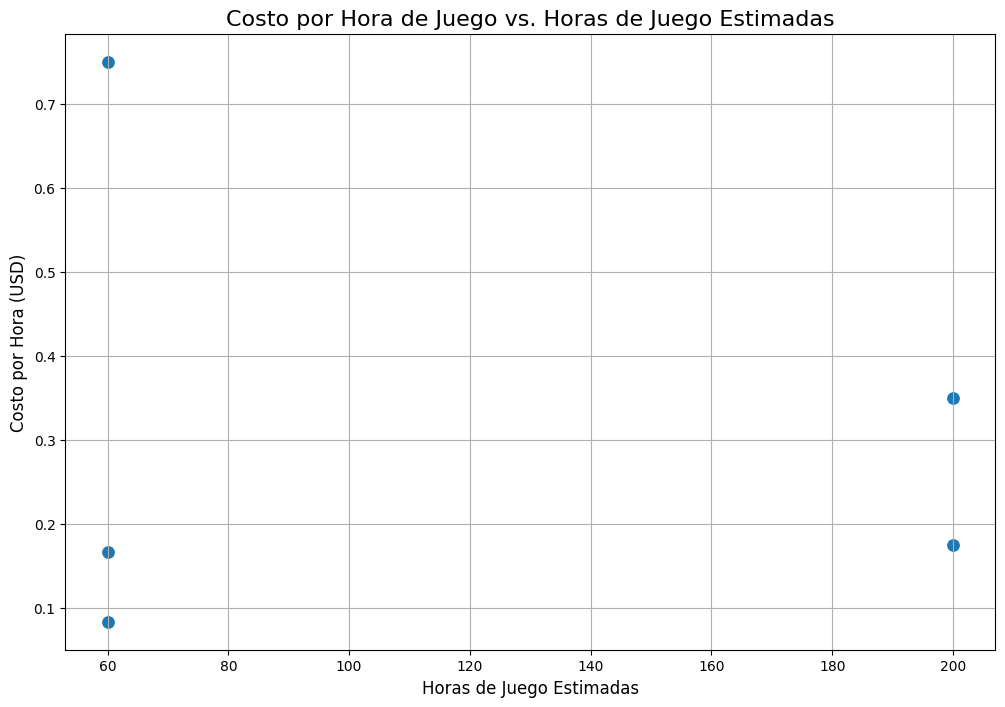

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Cargar los datos de la biblioteca
    biblioteca_df = pd.read_json("biblioteca.json")

    if biblioteca_df.empty:
        print("La biblioteca de juegos está vacía. Agrega juegos para poder generar la gráfica.")
    else:
        # Convertir 'tiempo_estimado' y 'costo' a numérico
        biblioteca_df['tiempo_estimado'] = pd.to_numeric(biblioteca_df['tiempo_estimado'], errors='coerce')
        biblioteca_df['costo'] = pd.to_numeric(biblioteca_df['costo'], errors='coerce')

        # Llenar valores NaN con 0
        biblioteca_df['tiempo_estimado'].fillna(0, inplace=True)
        biblioteca_df['costo'].fillna(0, inplace=True)

        # Calcular el costo por hora de juego, evitando división por cero
        biblioteca_df['costo_por_hora'] = biblioteca_df.apply(
            lambda row: row['costo'] / row['tiempo_estimado'] if row['tiempo_estimado'] > 0 else 0, axis=1
        )

        # Crear el gráfico de dispersión con el costo por hora
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=biblioteca_df, x='tiempo_estimado', y='costo_por_hora', s=100)

        # Añadir títulos y etiquetas
        plt.title('Costo por Hora de Juego vs. Horas de Juego Estimadas', fontsize=16)
        plt.xlabel('Horas de Juego Estimadas', fontsize=12)
        plt.ylabel('Costo por Hora (USD)', fontsize=12)
        plt.grid(True)
        plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo biblioteca.json. Asegúrate de que el archivo existe.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

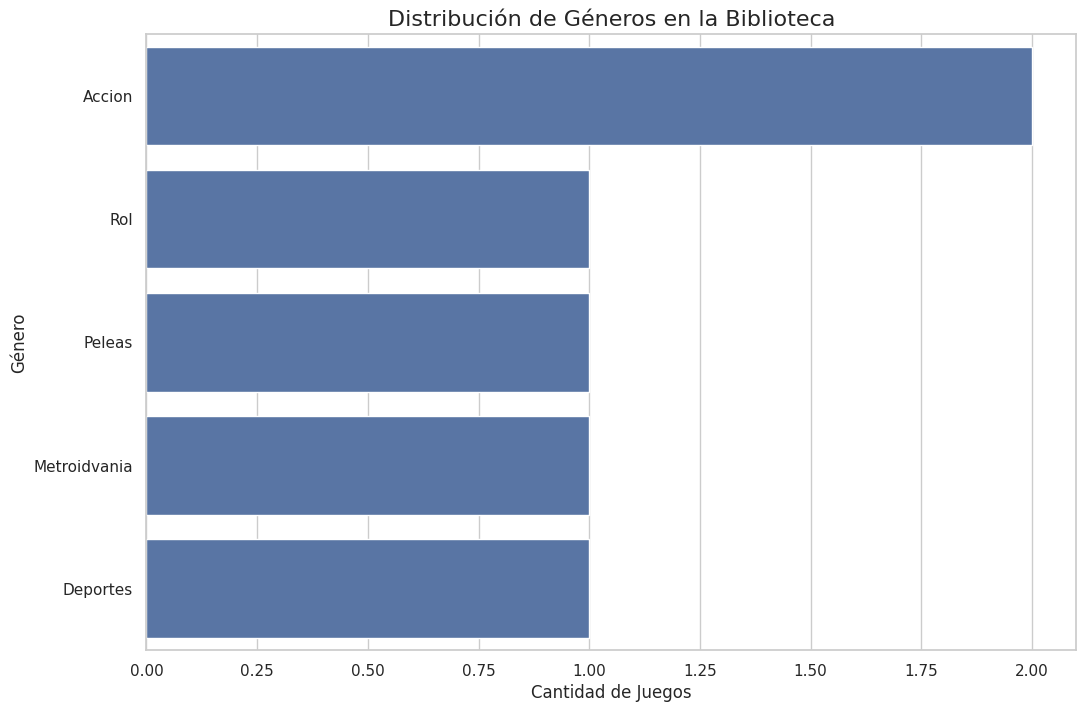

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de la visualización
sns.set(style="whitegrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras de la distribución de géneros
sns.countplot(y='genero', data=df, order = df['genero'].value_counts().index)

# Añadir títulos y etiquetas
plt.title('Distribución de Géneros en la Biblioteca', fontsize=16)
plt.xlabel('Cantidad de Juegos', fontsize=12)
plt.ylabel('Género', fontsize=12)

# Mostrar el gráfico
plt.show()

In [ ]:
import gradio as gr
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image

# Crear una instancia de la biblioteca
biblioteca = BibliotecaVideojuegos()
biblioteca.cargar_desde_archivo("biblioteca.json")

# --- Funciones para la Interfaz de Gradio ---

def agregar_juego_gradio(nombre, genero, tiempo, desarrollador, anio, costo):
    if not nombre:
        return "❌ El nombre del juego no puede estar vacío.", biblioteca.df
    biblioteca.agregar_juego(nombre, genero, tiempo, desarrollador, anio, costo)
    biblioteca.guardar_en_archivo("biblioteca.json")
    return f"✅ Juego '{nombre}' agregado correctamente.", biblioteca.df

def listar_juegos_gradio():
    return biblioteca.df

def editar_juego_gradio(identificador, nombre, genero, tiempo, desarrollador, anio, costo):
    if not identificador:
        return "❌ Debes ingresar el nombre o número del juego a editar.", biblioteca.df

    try:
        if identificador.isdigit():
            indice = int(identificador)
            if indice < 0 or indice >= len(biblioteca.df):
                return "❌ Índice fuera de rango.", biblioteca.df
        else:
            indice = biblioteca.df.index[biblioteca.df["nombre"].str.lower() == identificador.lower()].tolist()[0]
    except:
        return "❌ No se encontró el juego.", biblioteca.df

    nuevos_datos = {
        "nombre": nombre,
        "genero": genero,
        "tiempo_estimado": tiempo,
        "desarrollador": desarrollador,
        "anio": anio,
        "costo": costo
    }
    biblioteca.df.loc[indice] = nuevos_datos
    biblioteca.guardar_en_archivo("biblioteca.json")
    return f"✅ Juego actualizado correctamente.", biblioteca.df

def eliminar_juego_gradio(identificador):
    if not identificador:
        return "❌ Debes ingresar el número del juego a eliminar.", biblioteca.df
    try:
        indice = int(identificador)
        biblioteca.eliminar_juego(indice)
        biblioteca.guardar_en_archivo("biblioteca.json")
        return "🗑️ Juego eliminado correctamente.", biblioteca.df
    except (ValueError, IndexError):
        return "❌ Índice inválido o no encontrado.", biblioteca.df

def descargar_json_gradio():
    """Descarga la biblioteca en formato JSON y la devuelve como archivo."""
    biblioteca.guardar_en_archivo("biblioteca.json")
    return "biblioteca.json"

def generar_grafico_horas_por_genero():
    """Genera un gráfico de barras con la cantidad de horas por género."""
    if biblioteca.df.empty:
        return None, "La biblioteca está vacía. No hay datos para generar el gráfico."

    # Asegurarse de que 'tiempo_estimado' sea numérico
    biblioteca.df['tiempo_estimado'] = pd.to_numeric(biblioteca.df['tiempo_estimado'], errors='coerce').fillna(0)

    # Agrupar por género y sumar el tiempo estimado
    horas_por_genero = biblioteca.df.groupby('genero')['tiempo_estimado'].sum().sort_values(ascending=False)

    if horas_por_genero.empty:
        return None, "No hay datos válidos de tiempo estimado para generar el gráfico."


    plt.figure(figsize=(12, 7))

    # Usar un color que simule una barra de vida (verde o rojo, por ejemplo)
    # y un estilo que se asemeje a una barra de vida.
    # Aquí usaremos un color verde y un borde negro.
    sns.barplot(x=horas_por_genero.index, y=horas_por_genero.values, color='limegreen', edgecolor='black', linewidth=1.5)

    plt.title('Total de Horas Estimadas por Género (Estilo Barra de Vida)', fontsize=16)
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Total de Horas Estimadas', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Guardar el gráfico en un buffer y luego abrirlo como imagen PIL
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close() # Cerrar la figura para no mostrarla en la salida del notebook

    return img, "Gráfico de horas por género generado con estilo barra de vida."

def generar_grafico_costo_por_hora():
    """Genera un gráfico de dispersión del costo por hora de juego."""
    if biblioteca.df.empty:
        return None, "La biblioteca está vacía. No hay datos para generar el gráfico."

    # Asegurarse de que 'tiempo_estimado' y 'costo' sean numéricos
    biblioteca.df['tiempo_estimado'] = pd.to_numeric(biblioteca.df['tiempo_estimado'], errors='coerce').fillna(0)
    biblioteca.df['costo'] = pd.to_numeric(biblioteca.df['costo'], errors='coerce').fillna(0)

    # Calcular el costo por hora de juego, evitando división por cero
    biblioteca.df['costo_por_hora'] = biblioteca.df.apply(
        lambda row: row['costo'] / row['tiempo_estimado'] if row['tiempo_estimado'] > 0 else 0, axis=1
    )

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=biblioteca.df, x='tiempo_estimado', y='costo_por_hora', s=100, hue='nombre') # Añadir hue para identificar los juegos
    plt.title('Costo por Hora de Juego vs. Horas de Juego Estimadas', fontsize=16)
    plt.xlabel('Horas de Juego Estimadas', fontsize=12)
    plt.ylabel('Costo por Hora (USD)', fontsize=12)
    plt.grid(True)
    plt.legend(title='Juego', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover la leyenda fuera del gráfico
    plt.tight_layout()

    # Guardar el gráfico en un buffer y luego abrirlo como imagen PIL
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight') # Ajustar para incluir la leyenda
    buf.seek(0)
    img = Image.open(buf)
    plt.close() # Cerrar la figura

    return img, "Gráfico de costo por hora de juego generado."

def generar_grafico_valor_juegos_caros():
    """Genera un gráfico para visualizar los juegos más caros en relación a sus horas jugadas."""
    if biblioteca.df.empty:
        return None, "La biblioteca está vacía. No hay datos para generar el gráfico."

    # Asegurarse de que 'tiempo_estimado' y 'costo' sean numéricos
    biblioteca.df['tiempo_estimado'] = pd.to_numeric(biblioteca.df['tiempo_estimado'], errors='coerce').fillna(0)
    biblioteca.df['costo'] = pd.to_numeric(biblioteca.df['costo'], errors='coerce').fillna(0)

    # Calcular una métrica simple de "valor" (por ejemplo, horas jugadas / costo)
    # Evitar división por cero
    biblioteca.df['valor_por_dolar'] = biblioteca.df.apply(
        lambda row: row['tiempo_estimado'] / row['costo'] if row['costo'] > 0 else 0, axis=1
    )

    # Seleccionar los juegos más caros (por ejemplo, top 10 o un umbral)
    # Para este ejemplo, tomaremos los 5 juegos con mayor costo
    juegos_caros = biblioteca.df.sort_values(by='costo', ascending=False).head(5)

    if juegos_caros.empty:
         return None, "No hay juegos caros con datos válidos para generar el gráfico."


    plt.figure(figsize=(12, 8))
    # Usaremos un gráfico de barras para mostrar el "valor" de los juegos más caros
    sns.barplot(data=juegos_caros, x='nombre', y='valor_por_dolar', palette='viridis')
    plt.title('Valor por Dólar (Horas/Costo) de los Juegos Más Caros', fontsize=16)
    plt.xlabel('Juego', fontsize=12)
    plt.ylabel('Horas por Dólar', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Guardar el gráfico en un buffer y luego abrirlo como imagen PIL
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close() # Cerrar la figura

    return img, "Gráfico de valor por dólar de los juegos más caros generado."

def generar_grafico_prediccion_genero():
    """Genera un gráfico de predicción de género basado en la frecuencia."""
    if biblioteca.df.empty:
        return None, "La biblioteca está vacía. No hay datos para hacer una predicción."

    # Contar la frecuencia de cada género
    genero_counts = biblioteca.df['genero'].value_counts().reset_index()
    genero_counts.columns = ['genero', 'count']

    if genero_counts.empty:
        return None, "No hay datos de género válidos para hacer una predicción."

    # Tomar los géneros más frecuentes como sugerencias
    # Puedes ajustar cuántos géneros mostrar aquí
    top_generos = genero_counts.head(5)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_generos, x='genero', y='count', palette='coolwarm')
    plt.title('Sugerencia de Próximos Géneros de Juego (Basado en Frecuencia)', fontsize=16)
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Cantidad de Juegos en la Biblioteca', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Guardar el gráfico en un buffer y luego abrirlo como imagen PIL
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close() # Cerrar la figura

    mensaje = "Este gráfico sugiere géneros de juegos basados en la frecuencia de los géneros que ya tienes en tu biblioteca."
    return img, mensaje


# --- Creación de la Interfaz de Gradio ---

with gr.Blocks() as demo:
    gr.Markdown("## 🎮 Gestor de Biblioteca de Videojuegos")

    with gr.Tab("Listar Juegos"):
        juegos_df = gr.DataFrame(listar_juegos_gradio())
        listar_button = gr.Button("Refrescar Lista")
        listar_button.click(listar_juegos_gradio, outputs=juegos_df)
        descargar_button = gr.Button("Descargar Biblioteca (JSON)")
        descarga_output = gr.File(label="Descargar Archivo JSON")
        descargar_button.click(descargar_json_gradio, outputs=descarga_output)

    with gr.Tab("Estadísticas y Predicción"):
        gr.Markdown("### Estadísticas y Visualizaciones de la Biblioteca")
        with gr.Row():
            with gr.Column():
                gr.Markdown("#### Horas Estimadas por Género")
                grafico_horas_genero = gr.Image(label="Gráfico Horas por Género", type="pil")
                mensaje_horas_genero = gr.Label()
                generar_grafico_horas_button = gr.Button("Mostrar Gráfico Horas por Género")

            with gr.Column():
                gr.Markdown("#### Costo por Hora de Juego")
                grafico_costo_hora = gr.Image(label="Gráfico Costo por Hora", type="pil")
                mensaje_costo_hora = gr.Label()
                generar_grafico_costo_button = gr.Button("Mostrar Gráfico Costo por Hora")

        with gr.Row():
             with gr.Column():
                gr.Markdown("#### Valor por Dólar de Juegos Caros")
                grafico_valor_caros = gr.Image(label="Gráfico Valor Juegos Caros", type="pil")
                mensaje_valor_caros = gr.Label()
                generar_grafico_valor_button = gr.Button("Mostrar Gráfico Valor Juegos Caros")

        gr.Markdown("### Predicción de Próximo Género de Juego")
        with gr.Row():
             with gr.Column():
                grafico_prediccion = gr.Image(label="Gráfico de Predicción", type="pil")
                mensaje_prediccion = gr.Label()
                generar_grafico_prediccion_button = gr.Button("Mostrar Sugerencia de Género")


        generar_grafico_horas_button.click(generar_grafico_horas_por_genero, outputs=[grafico_horas_genero, mensaje_horas_genero])
        generar_grafico_costo_button.click(generar_grafico_costo_por_hora, outputs=[grafico_costo_hora, mensaje_costo_hora])
        generar_grafico_valor_button.click(generar_grafico_valor_juegos_caros, outputs=[grafico_valor_caros, mensaje_valor_caros])
        generar_grafico_prediccion_button.click(generar_grafico_prediccion_genero, outputs=[grafico_prediccion, mensaje_prediccion])


    with gr.Tab("Agregar Juego"):
        with gr.Row():
            nombre_input = gr.Textbox(label="Nombre")
            genero_input = gr.Textbox(label="Género")
        with gr.Row():
            tiempo_input = gr.Textbox(label="Tiempo (hrs)")
            desarrollador_input = gr.Textbox(label="Desarrollador")
        with gr.Row():
            anio_input = gr.Textbox(label="Año")
            costo_input = gr.Textbox(label="Costo (USD)")
        agregar_button = gr.Button("Agregar Juego")
        add_output = gr.Label()
        agregar_button.click(agregar_juego_gradio,
                             inputs=[nombre_input, genero_input, tiempo_input, desarrollador_input, anio_input, costo_input],
                             outputs=[add_output, juegos_df])

    with gr.Tab("Editar Juego"):
        gr.Markdown("Introduce el ID (número) o el nombre del juego que quieres editar, y luego llena los nuevos datos.")
        with gr.Row():
            edit_id_input = gr.Textbox(label="ID o Nombre del Juego a Editar")
        with gr.Row():
            edit_nombre_input = gr.Textbox(label="Nuevo Nombre")
            edit_genero_input = gr.Textbox(label="Nuevo Género")
        with gr.Row():
            edit_tiempo_input = gr.Textbox(label="Nuevo Tiempo (hrs)")
            edit_desarrollador_input = gr.Textbox(label="Nuevo Desarrollador")
        with gr.Row():
            edit_anio_input = gr.Textbox(label="Nuevo Año")
            edit_costo_input = gr.Textbox(label="Nuevo Costo (USD)")
        editar_button = gr.Button("Actualizar Juego")
        edit_output = gr.Label()
        editar_button.click(editar_juego_gradio,
                            inputs=[edit_id_input, edit_nombre_input, edit_genero_input, edit_tiempo_input, edit_desarrollador_input, edit_anio_input, edit_costo_input],
                            outputs=[edit_output, juegos_df])

    with gr.Tab("Eliminar Juego"):
        gr.Markdown("Introduce el ID (número) del juego que quieres eliminar.")
        delete_id_input = gr.Textbox(label="ID del Juego a Eliminar")
        eliminar_button = gr.Button("Eliminar Juego")
        delete_output = gr.Label()
        eliminar_button.click(eliminar_juego_gradio,
                              inputs=delete_id_input,
                              outputs=[delete_output, juegos_df])

demo.launch()

📥 Biblioteca cargada desde biblioteca.json
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0863c6cccf353a736c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
